In [1]:
# imports 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shapefile as shp

This dataset consists of 10 years of historical weather data from roughly 50 cities in Australia. This model will use weather observations taken at a city and use this data to try to predict if it will rain the following day. 

In [2]:
# set the style for the plotting 

sns.set(style= 'whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

%matplotlib inline

In [3]:
# visualization of AU and the cities 

#city data 
df =  pd.read_csv(r'C:\Users\Devin\desktop\thinkful\capstone2/au_cities.csv')

# get the shapefile in here 
shp_path = r'C:\Users\Devin\desktop\thinkful\capstone2\shape\ne_10m_coastline.shp'
sf = shp.Reader(shp_path)

#plot mat function for a shapefile 
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        
    

<ipython-input-4-0eb6ab52a5fa>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,1,1)


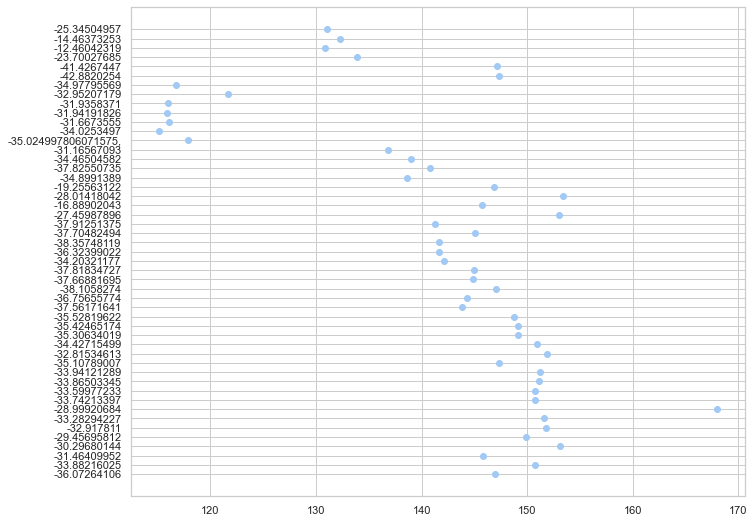

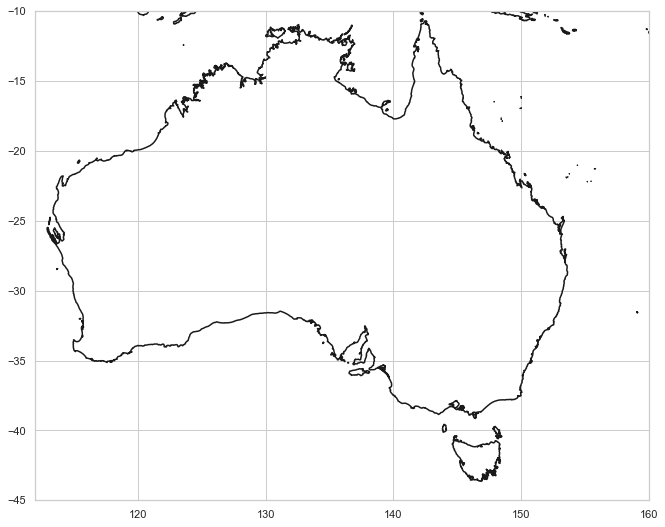

In [4]:
# plot it all 

#roughly the 

plt.figure(figsize = (11, 9))

plt.subplot(1,1,1)
plt.scatter(df.lat, df.long)


plt.subplot(1,1,1)
plot_map(sf, x_lim = (112, 160), y_lim = (-45, -10))
plt.show()


# plotted this using an old shapefile reader package from python... Was real challenging and couldn't find a way to get the 
# points on the same figure  

This chart has some issues, but still shows the general location of the cities covered by the model, as well as the challenge of the target class. I was unable to get both of the charts to plot on a single plot. 

In [5]:
#ok now for the analysis 


# get the data in 

raw_df = pd.read_csv(r'C:\Users\Devin\desktop\thinkful\capstone2\weatherAUS.csv')

In [6]:
# get the info on the dataset 

raw_df.info()

# the date is an object 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Ok, so the rain tomorrow column is the target for this project. We have data detailing temperature, rain, sun, wind, cloudcover, humidity and pressure. I feel it will be possible to predict the presence of rain within a reasonable 
level of accuracy. The cities sampled comprise a wide variety of climates, from tropical islands to desert. For such a wide variety of locations, and limited data to predict (only today's weather) I expect a limited amount of accuracy. Nonetheless, lets see how accurate it can be. 

In [7]:
# ok, lets start by working with the nan values and coming up with a good way to deal with them 

# first get a list of the columns with missing values 

raw_df.isna().any()

# missing values for every column except the date and location 

Date             False
Location         False
MinTemp           True
MaxTemp           True
Rainfall          True
Evaporation       True
Sunshine          True
WindGustDir       True
WindGustSpeed     True
WindDir9am        True
WindDir3pm        True
WindSpeed9am      True
WindSpeed3pm      True
Humidity9am       True
Humidity3pm       True
Pressure9am       True
Pressure3pm       True
Cloud9am          True
Cloud3pm          True
Temp9am           True
Temp3pm           True
RainToday         True
RainTomorrow      True
dtype: bool

In [8]:
# get the number of missing values 

raw_df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

Lots of missing values for clouds, evaporation and sunshine. Are these grouped by the location? Do specific weather stations lack the equipment to make these measurements or are they just missing? Lets explore this question. 

In [9]:
# clouds, evap and sunshine have many missing values , almost half 

# lets group by the location and see if it is consistent across weather reporting locations

location_grp = raw_df.groupby(['Location'])

In [10]:
raw_df.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [11]:
# there we go, a little more complicated than it should be 
# apply this labda function to get the number of missing values for evaporation grouped by the location 


location_grp['Evaporation'].apply( lambda x : x.isna().sum())

#seems mixed, some stations are missing all of the values, others are just missing some 

Location
Adelaide            1489
Albany               290
Albury              3040
AliceSprings         215
BadgerysCreek       3009
Ballarat            3040
Bendigo             1855
Brisbane              19
Cairns               370
Canberra            1604
Cobar                343
CoffsHarbour        1224
Dartmoor             409
Darwin                54
GoldCoast           3040
Hobart                 7
Katherine             93
Launceston          2899
Melbourne              3
MelbourneAirport       3
Mildura              117
Moree                717
MountGambier         410
MountGinini         3040
Newcastle           3039
Nhil                1578
NorahHead           3004
NorfolkIsland        234
Nuriootpa            122
PearceRAAF          3009
Penrith             3039
Perth                  1
PerthAirport           1
Portland             409
Richmond            1385
Sale                1175
SalmonGums          3001
Sydney                51
SydneyAirport         46
Townsville      

In [12]:
# lets look at clouds 
#same idea here for 9am clouds 

location_grp['Cloud9am'].apply(lambda x: x.isna().sum())

# roughly the same trend here.. 

Location
Adelaide            3193
Albany                38
Albury              1751
AliceSprings         334
BadgerysCreek       3009
Ballarat             546
Bendigo              968
Brisbane               1
Cairns               207
Canberra            1072
Cobar                380
CoffsHarbour         813
Dartmoor            3009
Darwin                 1
GoldCoast           3040
Hobart              1163
Katherine             41
Launceston          2315
Melbourne           1034
MelbourneAirport       0
Mildura               84
Moree                538
MountGambier         110
MountGinini         3040
Newcastle            241
Nhil                1578
NorahHead           3004
NorfolkIsland         66
Nuriootpa            127
PearceRAAF          1043
Penrith             3039
Perth                  2
PerthAirport           2
Portland             412
Richmond            2404
Sale                 358
SalmonGums          3001
Sydney               568
SydneyAirport          4
Townsville      

In [13]:
# examine the distribution of the wind directions 

raw_df['WindGustDir'].value_counts()

W      9915
SE     9418
N      9313
SSE    9216
E      9181
S      9168
WSW    9069
SW     8967
SSW    8736
WNW    8252
NW     8122
ENE    8104
ESE    7372
NE     7133
NNW    6620
NNE    6548
Name: WindGustDir, dtype: int64

Seems like the missing values were generally grouped by location. They weren't missing all of their values, therefore it seems that there wasn't just an issue of missing equipment at these stations. It is difficult to know why the data is missing. 

Now, the next order of buisness is the wind direction data. Currently, the data is all in object form. I am going to encode these from letter directions to degrees. This will result in far less dimensions for the algorithm than one hot encoding. 

In [14]:
# wind direction is an issue, it is an object data type 
# WindGustDir, WindDir9am, WindDir3pm are all objects, 


# ok, lets change these to compass directions 
#lets use a dictionary replace method 

#define the dictionary, consistent to first degree belonging to category 

compass_dir = { 'W': 258.75, 'SE': 123.75, 'N': 348.75, 'SSE': 146.25, 'E': 78.75, 'S': 168.75, 'WSW': 236.5, 'SW': 213.75, 
               'SSW': 191.25, 'WNW': 281.25, 'NW': 303.75, 'ENE': 56.25, 'ESE': 101.25, 'NE': 33.75, 'NNW': 326.25, 'NNE':11.25}

raw_df['WindGustDir'].replace(compass_dir, inplace=True)

In [15]:
#ok, that looks good, do it for the rest of the wind direction columns
raw_df['WindGustDir'].value_counts()

258.75    9915
123.75    9418
348.75    9313
146.25    9216
78.75     9181
168.75    9168
236.50    9069
213.75    8967
191.25    8736
281.25    8252
303.75    8122
56.25     8104
101.25    7372
33.75     7133
326.25    6620
11.25     6548
Name: WindGustDir, dtype: int64

In [16]:
raw_df['WindDir9am'].replace(compass_dir, inplace=True)


In [17]:
raw_df['WindDir3pm'].replace(compass_dir, inplace=True)

In [18]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  float64
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  float64
 10  WindDir3pm     141232 non-null  float64
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Looks good, all the wind directions have been encoded. Now the rain today and tomorrow columns have to be encoded to binary. 

In [19]:
# now we got to replace some values for the Rain today and tommorow columns 
raw_df['RainToday'].value_counts() 

# it is a binary, just make it 0 and 1 

No     110319
Yes     31880
Name: RainToday, dtype: int64

In [20]:
binary_dict = {'Yes': 1, 'No': 0}

raw_df['RainToday'].replace(binary_dict, inplace=True)

In [21]:
raw_df['RainToday'].value_counts()
#looks good 

0.0    110319
1.0     31880
Name: RainToday, dtype: int64

In [22]:
raw_df['RainTomorrow'].replace(binary_dict, inplace=True)

In [23]:
raw_df['RainTomorrow'].value_counts()

0.0    110316
1.0     31877
Name: RainTomorrow, dtype: int64

Now with some of the data type issues handled, it is time to move on to the missing values. We are going to use a median imputing strategy to handle them and fill them all. 

In [24]:
# lets just impute the missing values, might have to return here if we get low accuracy 

#prepare df for imputing 

df_pre_imputed = raw_df[['MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine','WindGustDir','WindGustSpeed','WindDir9am','WindDir3pm',
 'WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Temp9am','Temp3pm',
                    'RainToday', 'RainTomorrow']]


from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')

imputer.fit(df_pre_imputed)

X = imputer.transform(df_pre_imputed)

#DATE LOCATION not in, no missing values for these 

In [25]:
df_imputed = pd.DataFrame(X, columns= df_pre_imputed.columns, index = df_pre_imputed.index)

In [26]:
df_imputed.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,4.8,8.4,258.75,44.0,258.75,281.25,20.0,...,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0.0,0.0
1,7.4,25.1,0.0,4.8,8.4,281.25,44.0,326.25,236.50,4.0,...,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0.0,0.0
2,12.9,25.7,0.0,4.8,8.4,236.50,46.0,258.75,236.50,19.0,...,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,0.0,0.0
3,9.2,28.0,0.0,4.8,8.4,33.75,24.0,123.75,78.75,11.0,...,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0.0,0.0
4,17.5,32.3,1.0,4.8,8.4,258.75,41.0,56.25,303.75,7.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0


In [27]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MinTemp        145460 non-null  float64
 1   MaxTemp        145460 non-null  float64
 2   Rainfall       145460 non-null  float64
 3   Evaporation    145460 non-null  float64
 4   Sunshine       145460 non-null  float64
 5   WindGustDir    145460 non-null  float64
 6   WindGustSpeed  145460 non-null  float64
 7   WindDir9am     145460 non-null  float64
 8   WindDir3pm     145460 non-null  float64
 9   WindSpeed9am   145460 non-null  float64
 10  WindSpeed3pm   145460 non-null  float64
 11  Humidity9am    145460 non-null  float64
 12  Humidity3pm    145460 non-null  float64
 13  Pressure9am    145460 non-null  float64
 14  Pressure3pm    145460 non-null  float64
 15  Cloud9am       145460 non-null  float64
 16  Cloud3pm       145460 non-null  float64
 17  Temp9am        145460 non-nul

It is time to deal with location and date. Date can be changed to a pandas data time object, and then the integer value of year, month, and day can be extracted and turned into seperate columns. 

In [29]:
# look at the head of the date time to make the format string 

raw_df['Date']

# year , month , day 

0         2008-12-01
1         2008-12-02
2         2008-12-03
3         2008-12-04
4         2008-12-05
             ...    
145455    2017-06-21
145456    2017-06-22
145457    2017-06-23
145458    2017-06-24
145459    2017-06-25
Name: Date, Length: 145460, dtype: object

In [30]:
# change it 

raw_df['Date'] = pd.to_datetime(raw_df['Date'], format = '%Y-%m-%dT', errors='coerce')

In [31]:
#sucess!
raw_df['Date'].isna().any()

# now seperate these all into their own features 

False

In [32]:
# seperating into the seperate features 
raw_df['year'] = raw_df['Date'].dt.year
raw_df['month'] = raw_df['Date'].dt.month
raw_df['day'] = raw_df['Date'].dt.day

In [33]:
# check it out 
raw_df[['year', 'month', 'day']].head()

#looks good , add this to the feature set (df_imputed)



,year,month,day
0,2008,12,1
1,2008,12,2
2,2008,12,3
3,2008,12,4
4,2008,12,5


In [34]:
#add these into the imputed dataframe 
df_imputed['year'] = raw_df['year']

df_imputed['month'] = raw_df['month']

df_imputed['day'] = raw_df['day']

In [35]:
# now lets check to see if any are missing 
raw_df[['year', 'month', 'day']].isna().any()

# great, now we gotta encode location 

year     False
month    False
day      False
dtype: bool

Now it is time to deal with location. This one has to be one-hot encoded. 

In [36]:
from sklearn.preprocessing import OneHotEncoder 

encoder = OneHotEncoder()

loc = raw_df[['Location']]

location_encoded = encoder.fit_transform(loc)


In [37]:
# now put this to array 
location_encoded = location_encoded.toarray()



In [38]:
# now to data frame

location_encoded = pd.DataFrame(location_encoded)

In [39]:
location_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 49 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       145460 non-null  float64
 1   1       145460 non-null  float64
 2   2       145460 non-null  float64
 3   3       145460 non-null  float64
 4   4       145460 non-null  float64
 5   5       145460 non-null  float64
 6   6       145460 non-null  float64
 7   7       145460 non-null  float64
 8   8       145460 non-null  float64
 9   9       145460 non-null  float64
 10  10      145460 non-null  float64
 11  11      145460 non-null  float64
 12  12      145460 non-null  float64
 13  13      145460 non-null  float64
 14  14      145460 non-null  float64
 15  15      145460 non-null  float64
 16  16      145460 non-null  float64
 17  17      145460 non-null  float64
 18  18      145460 non-null  float64
 19  19      145460 non-null  float64
 20  20      145460 non-null  float64
 21  21      14

Now it is time to merge the two dataframes (one hot encoded values and all other columns). I will build a dummy index column in both to perform the merge of the two dataframes, and then merge them. Upon merging, the dummy index will be dropped. 

In [40]:
# ok, need a common column to perform the merge, use the index  

df_imputed['index_key'] = df_imputed.index

location_encoded['index_key'] = location_encoded.index

In [41]:
#now add the encoded features to the imputed data frame 
# use the merge function 

merged = pd.merge(df_imputed, location_encoded)



In [42]:
# ok we got it 
merged.shape

#feature scaling, outliers 

(145460, 74)

In [43]:
#drop useless index column used for the merge
merged.drop('index_key', axis=1, inplace=True)

In [44]:
merged.columns

Index([      'MinTemp',       'MaxTemp',      'Rainfall',   'Evaporation',
            'Sunshine',   'WindGustDir', 'WindGustSpeed',    'WindDir9am',
          'WindDir3pm',  'WindSpeed9am',  'WindSpeed3pm',   'Humidity9am',
         'Humidity3pm',   'Pressure9am',   'Pressure3pm',      'Cloud9am',
            'Cloud3pm',       'Temp9am',       'Temp3pm',     'RainToday',
        'RainTomorrow',          'year',         'month',           'day',
                     0,               1,               2,               3,
                     4,               5,               6,               7,
                     8,               9,              10,              11,
                    12,              13,              14,              15,
                    16,              17,              18,              19,
                    20,              21,              22,              23,
                    24,              25,              26,              27,
                    28,  

Now lets inspect the data for outliers. Start with the tukey method, and go from there. 

In [45]:
lst = ['MinTemp',       'MaxTemp',      'Rainfall',   'Evaporation',
            'Sunshine',   'WindGustDir', 'WindGustSpeed',    'WindDir9am',
          'WindDir3pm',  'WindSpeed9am',  'WindSpeed3pm',   'Humidity9am',
         'Humidity3pm',   'Pressure9am',   'Pressure3pm',      'Cloud9am',
            'Cloud3pm',       'Temp9am',       'Temp3pm',     'RainToday',
        'RainTomorrow',          'year',         'month',           'day']

#tukey's method or the IQR method 
# get the third and first quartiles to start 
q75, q25 =np.percentile(merged[lst], [75,25])
iqr = q75-q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((merged[lst] > max_val) 
                      | (merged[lst] < min_val))[0]))
    ))
    
    # ok we got a serious outlier issue here 

The score threshold is: 1.0
Number of outliers is: 697068
The score threshold is: 1.5
Number of outliers is: 658720
The score threshold is: 2.0
Number of outliers is: 592935
The score threshold is: 2.5
Number of outliers is: 567320
The score threshold is: 3.0
Number of outliers is: 514294
The score threshold is: 3.5
Number of outliers is: 466343
The score threshold is: 4.0
Number of outliers is: 436382
The score threshold is: 4.5
Number of outliers is: 436380


Lots of outliers in this dataframe. Lets plot boxplots of each feature to see what the distributions look like. 

C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the f

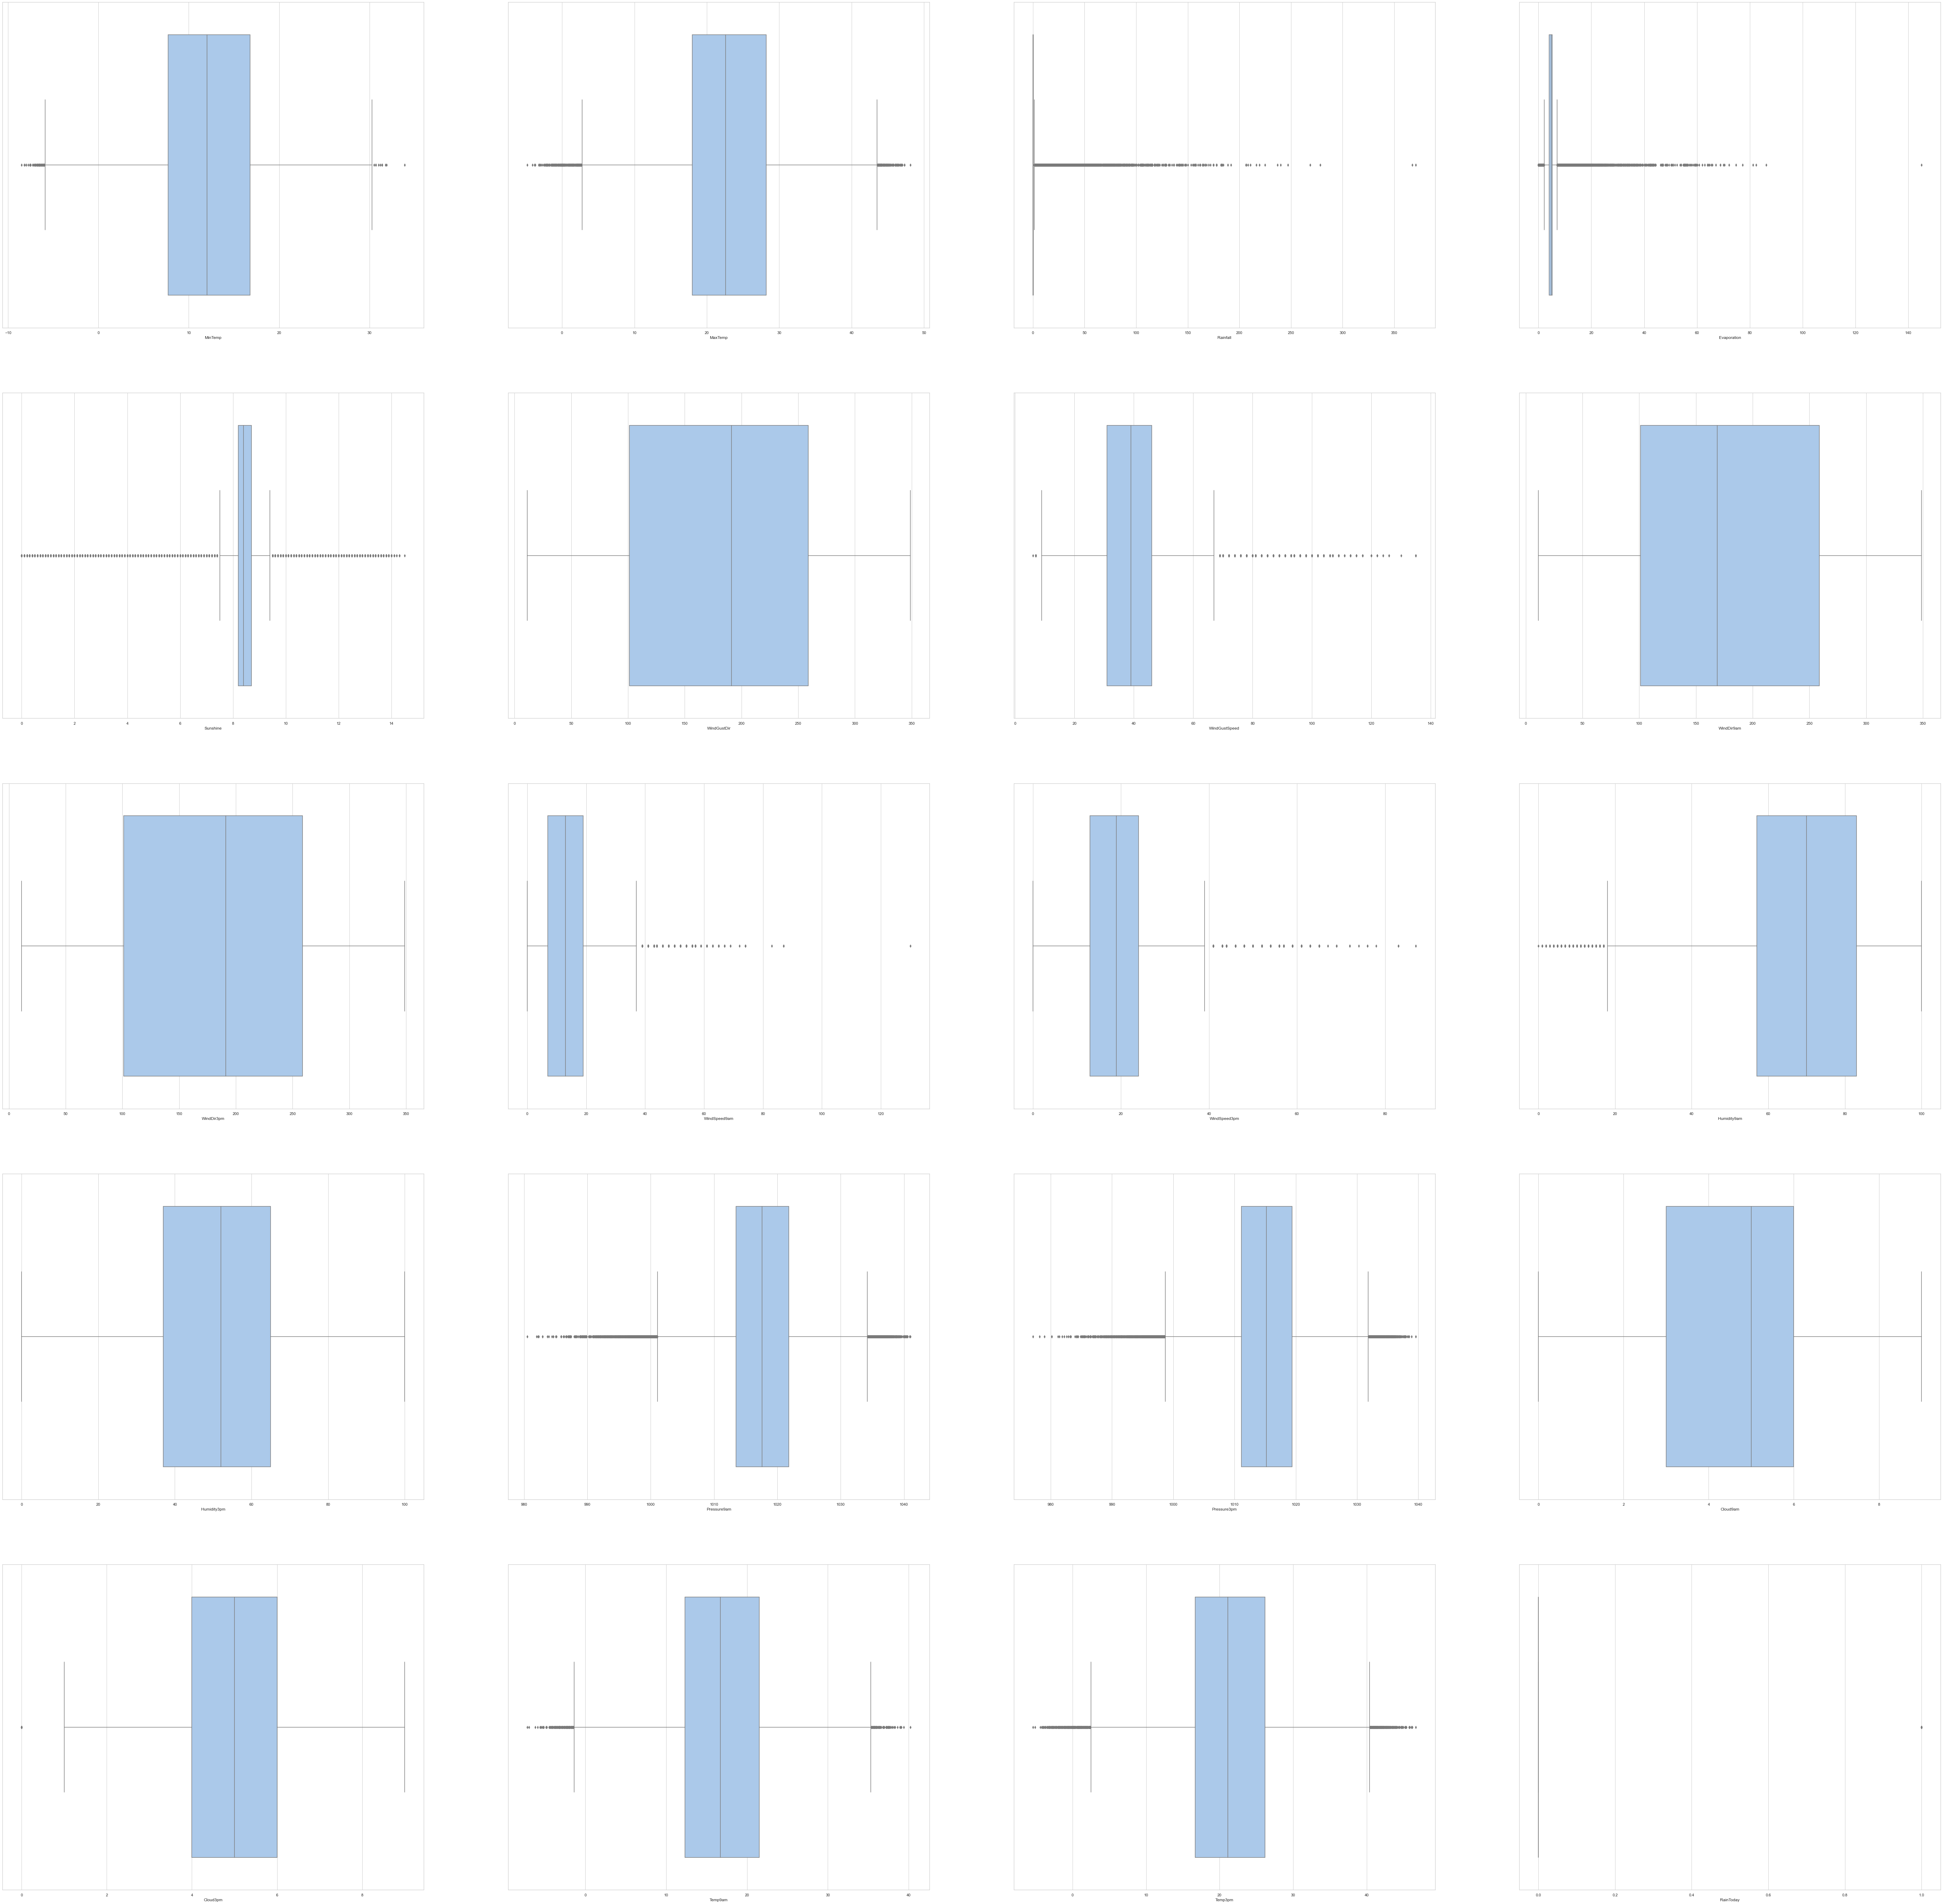

In [46]:
import seaborn as sns 
# lets plot em all in boxplots 

plt.figure(figsize = (100, 100))


plt.subplot(5,4,1)
sns.boxplot(merged[lst[0]])

plt.subplot(5,4,2)
sns.boxplot(merged[lst[1]])

plt.subplot(5,4,3)
sns.boxplot(merged[lst[2]])

plt.subplot(5,4,4)
sns.boxplot(merged[lst[3]])

plt.subplot(5,4,5)
sns.boxplot(merged[lst[4]])

plt.subplot(5,4,6)
sns.boxplot(merged[lst[5]])

plt.subplot(5,4,7)
sns.boxplot(merged[lst[6]])

plt.subplot(5,4,8)
sns.boxplot(merged[lst[7]])

plt.subplot(5,4,9)
sns.boxplot(merged[lst[8]])

plt.subplot(5,4,10)
sns.boxplot(merged[lst[9]])

plt.subplot(5,4,11)
sns.boxplot(merged[lst[10]])

plt.subplot(5,4,12)
sns.boxplot(merged[lst[11]])

plt.subplot(5,4,13)
sns.boxplot(merged[lst[12]])

plt.subplot(5,4,14)
sns.boxplot(merged[lst[13]])

plt.subplot(5,4,15)
sns.boxplot(merged[lst[14]])

plt.subplot(5,4,16)
sns.boxplot(merged[lst[15]])

plt.subplot(5,4,17)
sns.boxplot(merged[lst[16]])

plt.subplot(5,4,18)
sns.boxplot(merged[lst[17]])

plt.subplot(5,4,19)
sns.boxplot(merged[lst[18]])

plt.subplot(5,4,20)
sns.boxplot(merged[lst[19]])

plt.show()

# 19, 18, 17, 14, 13, 10, 9, 6, 4, 3, 2 all need some winsorizing 

Alright, apply a winsorization technique to remove some of the outliers. 

In [47]:
from scipy.stats.mstats import winsorize 

merged[lst[19]] = winsorize(merged[lst[19]], (0.10, 0.10))


merged[lst[18]] = winsorize(merged[lst[18]], (0.10, 0.10))


merged[lst[17]] = winsorize(merged[lst[17]], (0.10, 0.10))


merged[lst[14]] = winsorize(merged[lst[14]], (0.10, 0.10))


merged[lst[13]] = winsorize(merged[lst[13]], (0.10, 0.10))


merged[lst[10]] = winsorize(merged[lst[10]], (0.10, 0.10))


merged[lst[9]] = winsorize(merged[lst[9]], (0.10, 0.10))


merged[lst[6]] = winsorize(merged[lst[6]], (0.10, 0.10))


merged[lst[4]] = winsorize(merged[lst[4]], (0.10, 0.10))


merged[lst[3]] = winsorize(merged[lst[3]], (0.10, 0.10))


merged[lst[2]] = winsorize(merged[lst[2]], (0.10, 0.10))

Check to see how well that worked. 

C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the f

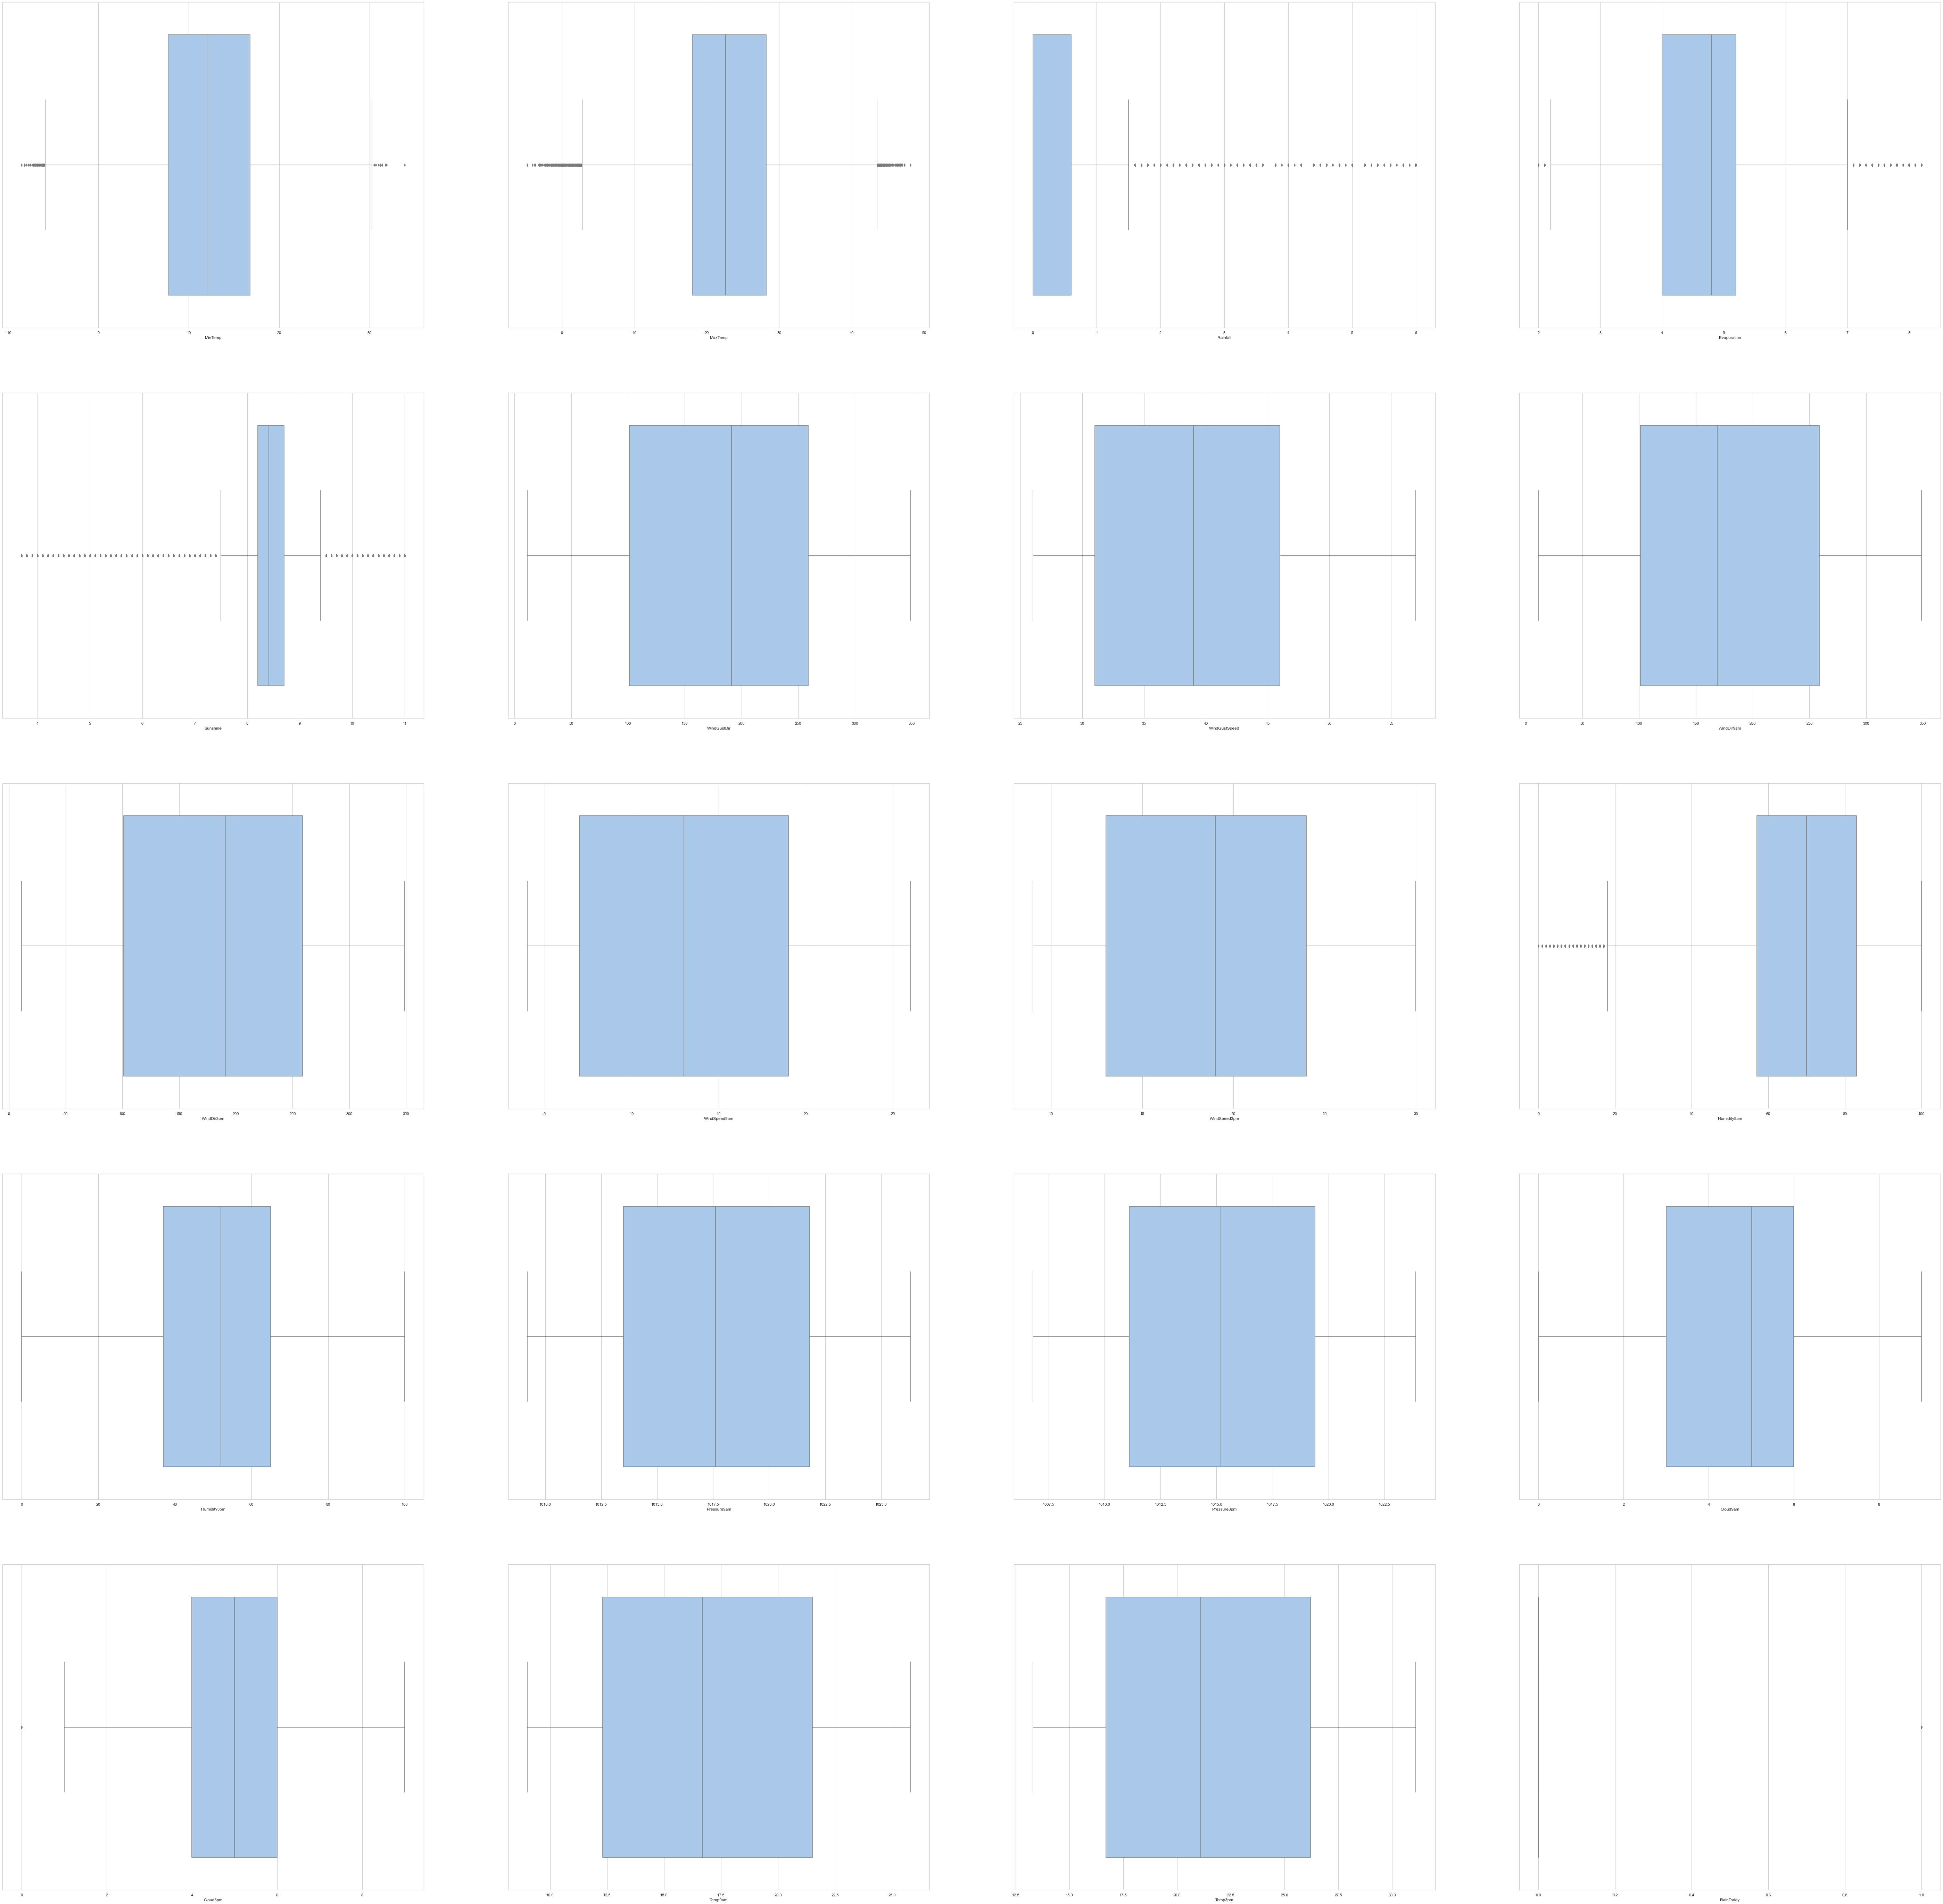

In [48]:
# lets plot em all in boxplots 

plt.figure(figsize = (100, 100))


plt.subplot(5,4,1)
sns.boxplot(merged[lst[0]])

plt.subplot(5,4,2)
sns.boxplot(merged[lst[1]])

plt.subplot(5,4,3)
sns.boxplot(merged[lst[2]])

plt.subplot(5,4,4)
sns.boxplot(merged[lst[3]])

plt.subplot(5,4,5)
sns.boxplot(merged[lst[4]])

plt.subplot(5,4,6)
sns.boxplot(merged[lst[5]])

plt.subplot(5,4,7)
sns.boxplot(merged[lst[6]])

plt.subplot(5,4,8)
sns.boxplot(merged[lst[7]])

plt.subplot(5,4,9)
sns.boxplot(merged[lst[8]])

plt.subplot(5,4,10)
sns.boxplot(merged[lst[9]])

plt.subplot(5,4,11)
sns.boxplot(merged[lst[10]])

plt.subplot(5,4,12)
sns.boxplot(merged[lst[11]])

plt.subplot(5,4,13)
sns.boxplot(merged[lst[12]])

plt.subplot(5,4,14)
sns.boxplot(merged[lst[13]])

plt.subplot(5,4,15)
sns.boxplot(merged[lst[14]])

plt.subplot(5,4,16)
sns.boxplot(merged[lst[15]])

plt.subplot(5,4,17)
sns.boxplot(merged[lst[16]])

plt.subplot(5,4,18)
sns.boxplot(merged[lst[17]])

plt.subplot(5,4,19)
sns.boxplot(merged[lst[18]])

plt.subplot(5,4,20)
sns.boxplot(merged[lst[19]])

plt.show()

# 19, 18, 17, 14, 13, 10, 9, 6, 4, 3, 2 all need some winsorizing # lets plot em all in boxplots 



Looks like a handful still need some outliers removed. 

In [49]:
# 0 thru 4 need some winsorizing 
#remove outlier on 19 
from scipy.stats.mstats import winsorize

merged[lst[0]] = winsorize(merged[lst[0]], (0.05, 0.05))

merged[lst[1]] = winsorize(merged[lst[1]], (0.05, 0.05))

merged[lst[2]] = winsorize(merged[lst[2]], (0.05, 0.05))

merged[lst[3]] = winsorize(merged[lst[3]], (0.05, 0.05))

merged[lst[4]] = winsorize(merged[lst[4]], (0.05, 0.05))



Check it out again, ensure the outliers are removed. 

C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the f

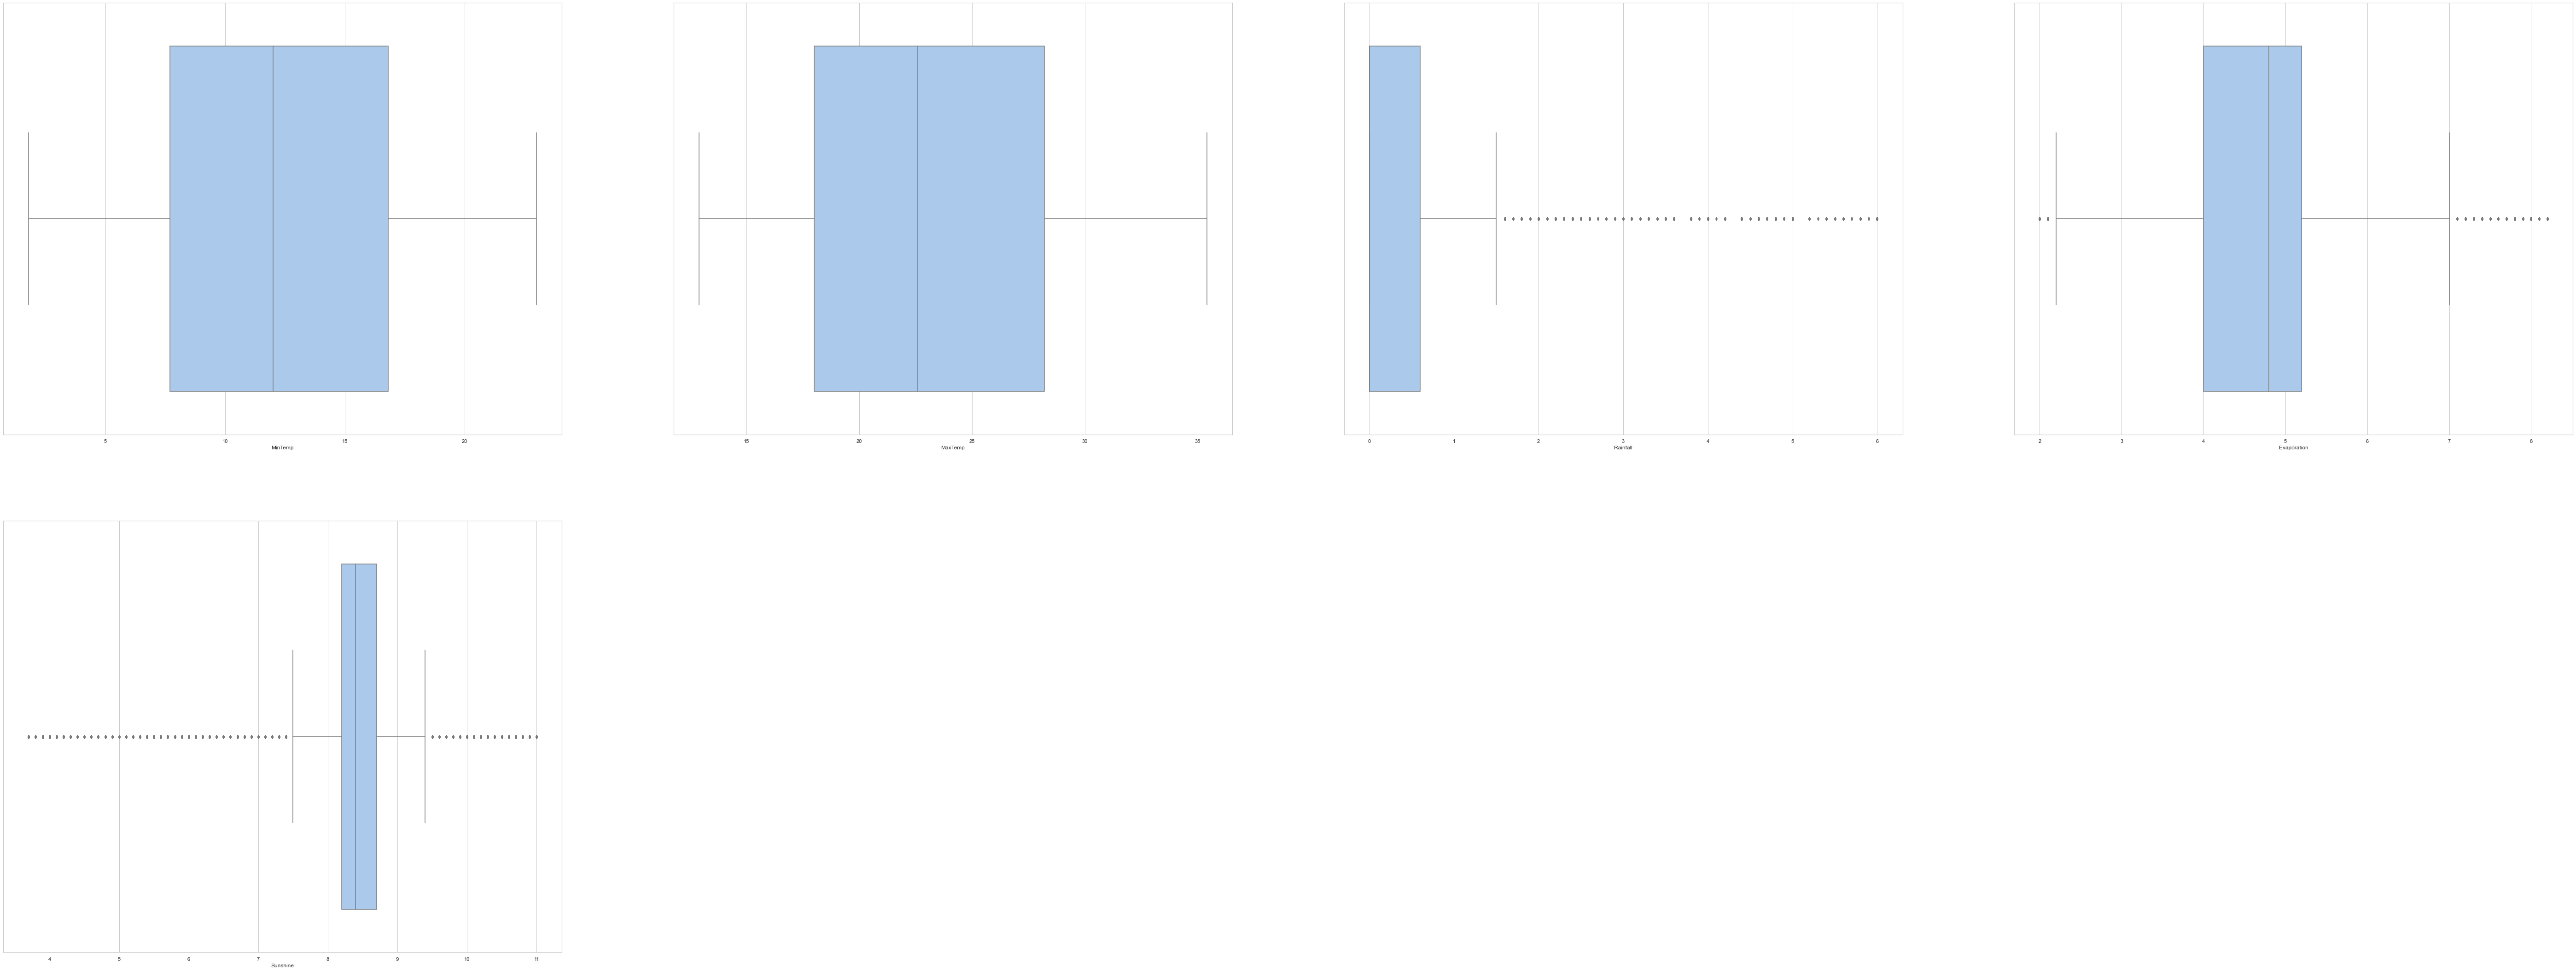

In [50]:
# lets plot em all in boxplots 

plt.figure(figsize = (100, 100))


plt.subplot(5,4,1)
sns.boxplot(merged[lst[0]])

plt.subplot(5,4,2)
sns.boxplot(merged[lst[1]])

plt.subplot(5,4,3)
sns.boxplot(merged[lst[2]])

plt.subplot(5,4,4)
sns.boxplot(merged[lst[3]])

plt.subplot(5,4,5)
sns.boxplot(merged[lst[4]])

plt.show()





In [51]:
# day has a strange distribution, look at the value counts 

merged['day'].value_counts()

# I guess this just doesnt want to plot nice, distribution looks good though 

16    4786
15    4786
2     4786
3     4786
4     4786
5     4786
6     4786
7     4786
8     4786
9     4786
10    4786
11    4786
12    4786
13    4786
14    4786
1     4786
17    4786
18    4786
19    4786
20    4786
21    4786
22    4786
23    4786
24    4785
25    4784
26    4736
27    4735
28    4735
29    4449
30    4351
31    2807
Name: day, dtype: int64

In [52]:
lst

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'RainTomorrow',
 'year',
 'month',
 'day']

In [53]:
merged['Rainfall'].value_counts()

0.0    94341
6.0    14613
0.2     8761
0.4     3782
0.6     2592
0.8     2056
1.0     1759
1.2     1535
1.4     1377
1.6     1200
1.8     1104
2.0     1037
2.2      986
2.4      844
2.6      841
2.8      727
3.0      712
3.2      669
3.4      605
3.8      598
3.6      567
4.0      557
4.2      522
4.4      460
5.0      451
4.6      441
4.8      423
5.2      403
5.4      371
5.6      366
5.8      346
0.1      157
0.3       65
0.5       39
0.9       15
1.5       14
0.7       13
1.9       10
1.7        9
2.3        9
2.1        8
2.5        8
1.3        8
1.1        8
4.5        6
3.5        6
3.1        6
5.5        6
3.3        5
4.7        4
2.9        4
3.9        3
4.9        3
2.7        2
5.9        2
5.7        2
5.3        1
4.1        1
Name: Rainfall, dtype: int64

Looking at rainfall here. It has a distribution that is far from normal. 

C:\conda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rainfall', ylabel='Density'>

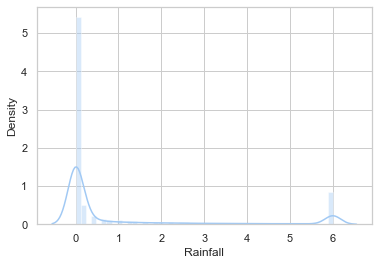

In [54]:
sns.distplot(merged['Rainfall'])

#just has a distribution like this... makes sense though 

Rainfall is just not normal. It has a wild distribution due to random extreme events and a variety of locations surveyed in the dataset. 

At this point, I am happy with the data. It has been encoded, outliers have been removed, and all the features are ready for the model. It is time to split up the X, Y and the training and test sets 

In [55]:
merged.columns

# all looks good though, ready to split these up 
# I am satisfied with the features 

Index([      'MinTemp',       'MaxTemp',      'Rainfall',   'Evaporation',
            'Sunshine',   'WindGustDir', 'WindGustSpeed',    'WindDir9am',
          'WindDir3pm',  'WindSpeed9am',  'WindSpeed3pm',   'Humidity9am',
         'Humidity3pm',   'Pressure9am',   'Pressure3pm',      'Cloud9am',
            'Cloud3pm',       'Temp9am',       'Temp3pm',     'RainToday',
        'RainTomorrow',          'year',         'month',           'day',
                     0,               1,               2,               3,
                     4,               5,               6,               7,
                     8,               9,              10,              11,
                    12,              13,              14,              15,
                    16,              17,              18,              19,
                    20,              21,              22,              23,
                    24,              25,              26,              27,
                    28,  

In [56]:
# split up the X and the Y 
X = merged.drop('RainTomorrow', axis=1)

In [57]:
y = merged['RainTomorrow']

In [58]:
X.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,39,40,41,42,43,44,45,46,47,48
0,13.4,22.9,0.6,4.8,8.4,258.75,44.0,258.75,281.25,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.4,25.1,0.0,4.8,8.4,281.25,44.0,326.25,236.50,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.9,25.7,0.0,4.8,8.4,236.50,46.0,258.75,236.50,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.2,28.0,0.0,4.8,8.4,33.75,26.0,123.75,78.75,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17.5,32.3,1.0,4.8,8.4,258.75,41.0,56.25,303.75,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here we will scale the feature set. Many modeles require a scaled feature set in order to produce accurate predictions. 

In [59]:
# try scaling X 

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

scaler.fit(X)

X = scaler.fit_transform(X)

X = pd.DataFrame(X)

In [60]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.198167,-0.046657,-0.205794,-0.049345,0.151838,0.772538,0.454124,0.750144,0.987471,0.874555,...,-0.1461,-0.146076,-0.104725,-0.145338,-0.145264,-0.145338,-0.145338,-0.145338,-0.1461,-0.145338
1,-0.805825,0.290847,-0.511379,-0.049345,0.151838,1.005153,0.454124,1.415050,0.534256,-1.369306,...,-0.1461,-0.146076,-0.104725,-0.145338,-0.145264,-0.145338,-0.145338,-0.145338,-0.1461,-0.145338
2,0.114501,0.382893,-0.511379,-0.049345,0.151838,0.542507,0.656213,0.750144,0.534256,0.734314,...,-0.1461,-0.146076,-0.104725,-0.145338,-0.145264,-0.145338,-0.145338,-0.145338,-0.1461,-0.145338
3,-0.504628,0.735738,-0.511379,-0.049345,0.151838,-1.553618,-1.364681,-0.579668,-1.063390,-0.387617,...,-0.1461,-0.146076,-0.104725,-0.145338,-0.145264,-0.145338,-0.145338,-0.145338,-0.1461,-0.145338
4,0.884229,1.395405,-0.002071,-0.049345,0.151838,0.772538,0.150990,-1.244574,1.215345,-0.948582,...,-0.1461,-0.146076,-0.104725,-0.145338,-0.145264,-0.145338,-0.145338,-0.145338,-0.1461,-0.145338


Alright, it is finally time to try fitting some models. Lets start with the random forest classifier. 

In [61]:
# try a model on this feature set 
# it is ready 

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

# scores = cross_val_score(rfc, X, y, scoring='neg_mean_squared_error', cv=3)

# scores = np.sqrt(-scores)

In [62]:
def display_scores(scores):
    print('scores:', scores)
    print('mean', scores.mean())

In [63]:
# display_scores(scores)

In [64]:
# no real difference.. 

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [65]:
rfc.fit(x_train, y_train)



RandomForestClassifier()

In [66]:
rfc.score(x_test, y_test)

0.8529836381135707

Lets compare this accuracy score with the score of the dummy classifier that predicts all days as not raining. 

In [67]:
# check this against the dummy 
from sklearn.dummy import DummyClassifier


dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(x_train, y_train)
dummy.score(x_test, y_test)

#ok, we are a tad more accuracte than the dummy, 7% more accurate... we can do better than that 

0.7754365461295202

~ 85% accuracy vs the dummy of ~77%. Honestly not that bad when you take into account the entire picture (only data related to the day of, huge variance in the weather of the locations included.) 

Lets try another model to see if we can increase the accuracy. 

In [68]:
# lets try a support vector machine 

# from sklearn.svm import SVC 

# svc= SVC()

# svc.fit(x_train, y_train)


In [69]:
# predicted = svc.predict(x_test)


In [70]:
# from sklearn.metrics import accuracy_score

# print(accuracy_score(y_test, predicted))

#this model takes absurdly long and does not result in a significant improvement in accuracy 

#stick with the random forrest classifier 

The support vector machine took a very long time to fit, and resulted in no significant increase in accuracy. Not worth changing over to this model. 

Now time to tune the hyperparmeters. 

In [75]:
# try the random search cv. we have covered all the bases on the feature engineering 
from sklearn.model_selection import RandomizedSearchCV


param_grid = dict()
param_grid['max_depth'] = np.arange(1,120,5)
param_grid['max_features'] = [2, 3]
param_grid['min_samples_leaf'] =  [3, 4, 5]
param_grid['min_samples_split'] = [8, 10, 12]
param_grid['n_estimators'] = [100, 200, 300, 1000]

search = RandomizedSearchCV(rfc, param_grid, cv=3, n_jobs=-1, verbose=2)

In [76]:
search.fit(X,y)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': array([  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
        66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116]),
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [100, 200, 300, 1000]},
                   verbose=2)

In [78]:
search.best_estimator_

RandomForestClassifier(max_depth=51, max_features=3, min_samples_leaf=3,
                       min_samples_split=10)

We got the best params from the search, now lets fit the model with these params. 

In [79]:
# max_depth = 51, max_features = 3, min_samples_leaf= 3, min_samples_split=10, n_estimators = 300 
# this the best performing set of hyperparameters 

#now get score on this new model 

rfc= RandomForestClassifier(max_depth = 51, max_features = 3, min_samples_leaf = 3, min_samples_split = 10, n_estimators =300)

rfc.fit(x_train, y_train)

RandomForestClassifier(max_depth=51, max_features=3, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=300)

In [80]:
rfc.score(x_test, y_test)

0.8481369448645676

Lets define a function to plot a confusion matrix, and then plot the matrix. 

In [81]:
# get the confusion matrix for this model 

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
  import matplotlib.pyplot as plt 
  import numpy as np
  import itertools

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy 

  if cmap is None:
    cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(10,8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]

  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
      plt.text(j, i, "{:,}".format(cm[i,j]), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

In [82]:
# get the confusion matrix 

from sklearn.metrics import confusion_matrix

predictions = rfc.predict(x_test)

confusion = confusion_matrix(y_test, predictions, labels=[1, 0], normalize='true') 

NameError: name 'j' is not defined

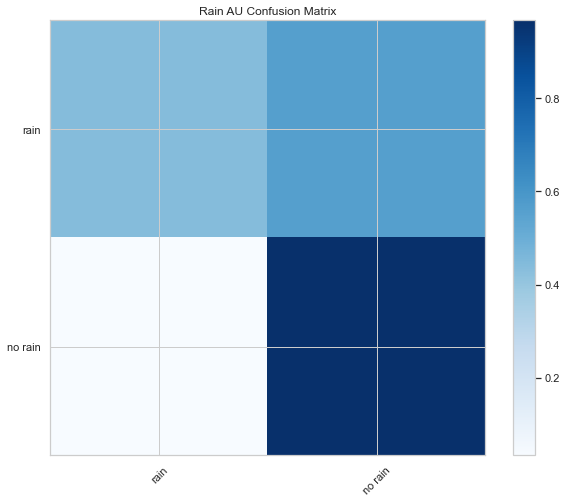

In [83]:
plot_confusion_matrix(confusion, target_names=['rain', 'no rain'], title='Rain AU Confusion Matrix')

Now get the classificaiton report, a report with metrics on the model's accuracy. 

In [ ]:
# get the classification report 

from sklearn.metrics import classification_report 

report = classification_report(y_test, predictions, target_names = ['no rain', 'rain'])

print(report)

NameError: name 'fplt' is not defined

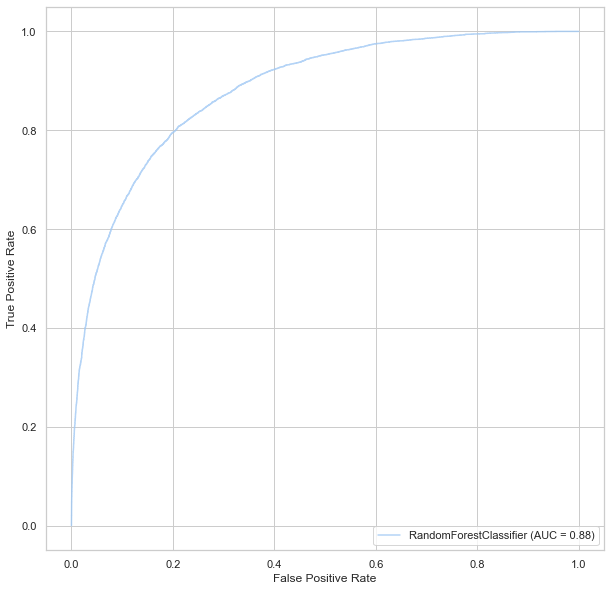

In [84]:
from sklearn.metrics import plot_roc_curve 

plt.figure(figsize=(10,10))

ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, x_test, y_test, ax=ax, alpha=0.8)
fplt.show()

The model makes the majority of its mistakes on the the rainy days. It only classifies roughly half of the days correctly. Overall, this is actually not that bad, as it only takes into account the weather at the current location. Actual weather forecasting models take into account radar, and obseravtions beyond the scope of the location. Therefore, I am actually very impressed with the performance of this model. 